In [1]:
from numpy.random import default_rng
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from collections import Counter
from collections import deque
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import random
import time

rng = default_rng()

In [43]:
# Function that executes a tensor product over an ordered list of objects(arrays or matrices)
# specified by the argument "k".
def tensor(k):
    t = k[0]
    i = 1
    while i < len(k) :
        t = np.kron(t,k[i])
        i+=1
    return t


def graph_to_hamiltonian(G,n): 
    H = np.zeros((2**n), dtype = 'float64') 
    Z = np.array([1,-1],dtype = 'float64')
    for i in range(n):
        j = i+1
        while j<n: 
            k = [[1,1]]*n 
            k = np.array(k,dtype = 'float64')
            if G[i][j] !=0: 
                k[i] = Z
                k[j] = Z
                H+= tensor(k)*G[i][j] 
            j+=1
    return H

def ZZ(G, i, j, n): 
    Z = np.array([1,-1],dtype = 'float64')
    k = [[1,1]]*n 
    k = np.array(k,dtype = 'float64')    
    if G[i][j] != 0: 
        k[i] = Z
        k[j] = Z
    return tensor(k)*G[i][j] 


def Z(i, n): 
    Z = np.array([1,-1],dtype = 'float64')
    k = [[1,1]]*n 
    k = np.array(k,dtype = 'float64')    
    k[i] = Z
    return  tensor(k)


def compute_subgraph_for_edge(G, u, v):
    v_sub = nx.Graph()
    v_sub.add_edge(u, v)
    for n in G.neighbors(u):
        v_sub.add_edge(u, n)
    for n in G.neighbors(v):
        v_sub.add_edge(v, n)
    old_nodes = list(v_sub.nodes)
    mapping = {old: new for new, old in enumerate(old_nodes)}
    v_sub = nx.relabel_nodes(v_sub, mapping)
    new_u = mapping[u]
    new_v = mapping[v]
    n_sub = len(list(v_sub.nodes))
    return v_sub, n_sub, new_u, new_v

# Generates a random k-sat instance
def k_sat_instance (n,k,m):
    instance=np.array([])
    for mind in range(m):
        clause = rng.choice(n, size=k, replace=False)
        instance=np.append(instance,clause)
    instance=(instance+1) *((-1)**np.random.randint(2,size=k*m))
    return  instance.reshape(m,k)

# Converts the k-sat instance into a Hamiltonian
def H_sat(inst,n):
    I=[1,1]
    k0=[1,0]
    k1=[0,1]
    inst_tp=0
    for mind in range(inst.shape[0]):
        clause=inst[mind]
        clause_list=[I]*n
        for lind in range(inst.shape[1]):
            if clause[lind]<0:
                clause_list[int(np.abs(clause[lind])-1)]=k1
            else:
                clause_list[int(np.abs(clause[lind])-1)]=k0
        clause_tp=tensor(clause_list)
        inst_tp=inst_tp+clause_tp
    return np.array(inst_tp)

In [3]:
def sample_from_state(state, n, shots=100, return_probs=False):
    state = state.reshape(-1)
    probs = np.abs(state) ** 2
    indices = np.random.choice(len(probs), size=shots, p=probs)
    most_common_index = Counter(indices).most_common(1)
    bitstring = format(most_common_index[0][0], f"0{n}b")
    if return_probs:
        return bitstring, probs
    return bitstring

def find_assignment(G, constraints):
    assignment = {}
    for start in G.nodes:
        if start in assignment:
            continue
        assignment[start] = 0
        queue = deque([start])
        while queue:
            u = queue.popleft()
            for v in G.neighbors(u):
                if (u, v) in constraints:
                    sign = constraints[(u, v)]
                elif (v, u) in constraints:
                    sign = constraints[(v, u)]
                else:
                    continue
                expected = assignment[u] if sign == 1 else 1 - assignment[u]
                if v not in assignment:
                    assignment[v] = expected
                    queue.append(v)
                else:
                    if assignment[v] != expected:
                        raise ValueError(f"Constraints are inconsistent node: {u}, {assignment[v]} != {expected}. Constraints {constraints}")
    return assignment

`U_gamma`: $$|\psi\rangle e^{-i\gamma H_{C}}=\left(\begin{array}{c}
\alpha_{0}\\
\alpha_{1}\\
\alpha_{2}\\
\alpha_{3}
\end{array}\right)e^{-i\gamma\left(\begin{array}{c}
\beta_{0}\\
\beta_{1}\\
\beta_{2}\\
\beta_{3}
\end{array}\right)}=\left(\begin{array}{c}
\alpha_{0}e^{-i\gamma\beta_{0}}\\
\alpha_{1}e^{-i\gamma\beta_{1}}\\
\alpha_{2}e^{-i\gamma\beta_{2}}\\
\alpha_{3}e^{-i\gamma\beta_{3}}
\end{array}\right)$$

`new_mixerX`: 
Applying $e^{-i\beta X}$ to the qubit $i$ swaps amplitudes of basis states whose binary labels differ only at bit $i$. This method precomputes index permutations to later apply Pauli-X efficiently (via array indexing).


`V_beta`:
If the number of qubits is $n=1$: $$|\psi\rangle=\cos\beta|\psi\rangle-i\sin\beta X_{i}|\psi\rangle $$

If $n>1$, for each qubit $i=0,...,n-1$ update the state as follows: $$|\psi^{(i)}\rangle=\cos\beta|\psi^{(i-1)}\rangle-i\sin\beta X_{i}|\psi^{(i-1)}\rangle)$$

In each iteration we apply X to qubit $i$ and reindex the state vector



In [4]:
class QAOA:
    def __init__(self,depth,H):     # Class initialization. Arguments are "depth",
                                            # and a Diagonal Hamiltonian,"H".
        self.H = H 
        self.n = int(np.log2(int(len(self.H)))) # Calculates the number of qubits.

        #______________________________________________________________________________________________________
        self.X = self.new_mixerX()        # Executes a sequence of array manipulations to encapsulate the
                                                # effect of standard one body driver hamiltonian, \Sum \sigma_x,
                                                # acting on any state.
        #______________________________________________________________________________________________________


        self.min = min(self.H)                  # Calculates minimum of the Hamiltonain, Ground state energy.

        self.deg = len(self.H[self.H == self.min]) # Calculates the degeneracy of Ground states.
        self.p = depth                             # Standard qaoa depth written as "p".

        #______________________________________________________________________________________________________

                    # The sequence of array manipulations that return action of the driver,
                    # in terms of permutation indices.

    def new_mixerX(self):
        def split(x,k):
            return x.reshape((2**k,-1))
        def sym_swap(x):
            return np.asarray([x[-1],x[-2],x[1],x[0]])

        n = self.n
        x_list = []
        t1 = np.asarray([np.arange(2**(n-1),2**n),np.arange(0,2**(n-1))])
        t1 = t1.flatten()
        x_list.append(t1.flatten())
        t2 = t1.reshape(4,-1)
        t3 = sym_swap(t2)
        t1 = t3.flatten()
        x_list.append(t1)

        k = 1
        while k < (n-1):
            t2 = split(t1,k)
            t2 = np.asarray(t2)
            t1=[]
            for y in t2:
                t3 = y.reshape((4,-1))
                t4 = sym_swap(t3)                
                t1.append(t4.flatten())
            t1 = np.asarray(t1)
            t1 = t1.flatten()
            x_list.append(t1)
            k+=1

        return x_list
    #__________________________________________________________________________________________________________


    def U_gamma(self,angle,state):       # applies exp{-i\gamma H_z}, here as "U_gamma", on a "state".
        t = -1j*angle
        H_new = self.H.reshape(2**self.n,1)
        
        state = state*np.exp(t*self.H.reshape(2**self.n,1))

        return state

    
    def V_beta(self,angle,state):        # applies exp{-i\beta H_x}, here as "V_beta", on a "state".
        c = np.cos(angle)
        s = np.sin(angle)

        for i in range(self.n):
            t = self.X[i]
            st = state[t]
            state = c*state + (-1j*s*st)

        return state

    #__________________________________________________________________________________________________________

                        # This step creates the qaoa_ansatz w.r.t to "angles" that are passed.
                        # "angles" are passed as [gamma_1,gamma_2,...,gamma_p,beta_1,beta2,....beta_p].

    def qaoa_ansatz(self, angles):
        
        state = np.ones((2**self.n,1),dtype = 'complex128')*(1/np.sqrt(2**self.n))
        
        for i in range(self.p):
            state = self.U_gamma(angles[i],state)
            state = self.V_beta(angles[self.p + i],state)

        return state


    #__________________________________________________________________________________________________________


    def expectation(self,angles):   # Calculates expected value of the Hamiltonian w.r.t qaoa_ansatz state,
                                           # defined by the specific choice of "angles".
                                                                   
        state = self.qaoa_ansatz(angles)
        ex = np.vdot(state,state*(self.H).reshape((2**self.n,1)))
        return  np.real(ex)
    

    def overlap(self,state):        # Calculates ground state overlap for any "state",
                                                        # passed to it. Usually the final state  or "f_state" returned,
                                                        # after optimization.

        g_ener = min(self.H)
        olap = 0
        for i in range(len(self.H)):
            if self.H[i] == g_ener:
                olap+= np.absolute(state[i])**2

        return olap

   #__________________________________________________________________________________________________________

                    # Main execution of the algorithm.
                    # 1) Create "initial_angles", this would be the guess or
                    #    starting point for the optimizer.
                    # 2) Optimizer "L-BFGS-B" then takes "initial_angles" and calls "expectation".
                    # 3) "expectation" then returns a number and the optimizer tries to minimize this,
                    #     by doing finite differences. Thermination returns optimized angles,
                    #     stored here as "res.x".
                    # 4) Treating the optimized angles as being global minima for "expectation",
                    #    we calculate and store (as class attributes) the qaoa energy, here as "q_energy",
                    #    energy error, here as "q_error",
                    #    ground state overlap, here as "olap"
                    #    and also the optimal state, here as "f_state"

    def run(self):
        initial_angles=[]
        bds= [(0,2*np.pi+0.1)]*self.p + [(0,1*np.pi+0.1)]*self.p
        for i in range(2*self.p):
            if i < self.p:
                initial_angles.append(random.uniform(0,2*np.pi))
            else:
                initial_angles.append(random.uniform(0,np.pi))

        # start = time.perf_counter()
        res = minimize(self.expectation,initial_angles,method='L-BFGS-B', jac=None, bounds=bds, options={'maxiter': 1000})
     
        # elapsed = time.perf_counter() - start
        # res = differential_evolution(self.expectation, bds,maxiter=100, callback=None, disp=False, init='latinhypercube',workers=-1)
    
        self.q_energy = self.expectation(res.x)
        self.q_error = self.q_energy - self.min
        self.f_state = self.qaoa_ansatz(res.x)
        self.olap = self.overlap(self.f_state)[0]
        self.angles = res.x
        self.best_bitstring = np.binary_repr(int(np.argmax(np.abs(self.f_state))), width=self.n)
        
    
        
     #__________________________________________________________________________________________________________


The Light Cones method leverages on the following property of the expectation function:
$$\langle\psi|H|\psi\rangle=\underset{(u,v)\in E}{\sum}\langle\psi|Z_{u}Z_{v}|\psi\rangle$$

It involves decomposing the $|V|$ qubits circuit into $|E|$ smaller sub-circuits:
- Assuming $p=1$, for each edge $(u,v)$, we have a sub-circuit with $deg(u)+deg(v)$ qubits

We decompose, we measure and reconstruct the expectations.

In practice, every time we want to compute the expectation value of the Hamiltonian, we iterate over the edges and:
- compute the subgraph
- compute the small Hamiltonian starting from the subgraph
- constrcut the ansatz that applies the small Hamiltonian
- measure 

In [70]:
class LightCone:
    def __init__(self, G, u, v, p):
        self.u, self.v = u, v
        self.v_sub, self.n_sub, self.new_u, self.new_v = compute_subgraph_for_edge(G, u, v)
        self.H = graph_to_hamiltonian(nx.to_numpy_array(self.v_sub), self.n_sub)
        self.Z_uZ_v = ZZ(nx.to_numpy_array(self.v_sub), self.new_u, self.new_v, self.n_sub)
        self.Q = QAOA(p, self.H)
        
    def expectation(self, angles):
        state = self.Q.qaoa_ansatz(angles)
        col_shape = (2**self.Q.n, 1)
        ex = np.vdot(state, state * self.Z_uZ_v.reshape(col_shape))
        return np.real(ex)

class Simulation:
    def __init__(self, G, p):
        self.G = G
        self.p = p
        self.light_cones = []
        for u, v in self.G.edges:
            self.light_cones.append(LightCone(G, u, v, p))

    def sum_of_expectations(self, angles):
        total_energy = 0.0
        for lc in self.light_cones:
            total_energy += lc.expectation(angles)
        return total_energy
    
    def sample_from_expectations(self, angles, shots=100):
        edge_weights = {}
        for lc in self.light_cones:
            expectation = lc.expectation(angles)
            # If expval = -1, prob_different = 1.0
            # If expval = 1, prob_different = 0.0
            # If expval = 0, prob_different = 0.5
            prob_different = 0.5 * (1 - expectation)
            edge_weights[(lc.u, lc.v)] = prob_different
        samples = {}
        for _ in range(shots):
            assignment = {}
            nodes = list(self.G.nodes())
            np.random.shuffle(nodes)
            assignment[nodes[0]] = np.random.randint(0, 2)
            for i in range(1, len(nodes)):
                u = nodes[i]
                neighbors = [n for n in self.G.neighbors(u) if n in assignment]
                if not neighbors:
                    assignment[u] = np.random.randint(0, 2)
                else:
                    votes_for_0 = 0
                    votes_for_1 = 0
                    for v in neighbors:
                        p_diff = edge_weights.get((u, v)) or edge_weights.get((v, u))
                        val_v = assignment[v]
                        if val_v == 0:
                            votes_for_1 += p_diff
                            votes_for_0 += (1 - p_diff)
                        else:
                            votes_for_0 += p_diff
                            votes_for_1 += (1 - p_diff)
                    total_votes = votes_for_0 + votes_for_1
                    prob_1 = votes_for_1 / total_votes
                    assignment[u] = 1 if np.random.random() < prob_1 else 0
            sorted_nodes = sorted(self.G.nodes())
            bitstring = "".join(str(assignment[n]) for n in sorted_nodes)
            samples[bitstring] = samples.get(bitstring, 0) + 1        
        return max(samples.items(), key=lambda x:x[1])
    
    def run(self): 
        initial_angles=[]
        bds= [(0,2*np.pi+0.1)]*self.p + [(0,1*np.pi+0.1)]*self.p
        for i in range(2*self.p):
            if i < self.p:
                initial_angles.append(random.uniform(0,2*np.pi))
            else:
                initial_angles.append(random.uniform(0,np.pi))
        res = minimize(self.sum_of_expectations,initial_angles,method='L-BFGS-B', jac=None, bounds=bds, options={'maxiter': 1000})
        self.angles = res.x
            

Before removal: $H_{n}=\underset{(p,q)\in E}{\sum}J_{p,q}Z_{p}Z_{q}$

Removal of the qubit `q`:

1. Replace $Z_{q}=sgn(M_{p,q})Z_{p}$ in the Hamiltonian
2. The Hamiltonian becomes: $$H_{n-1}=J_{p,q}sgn(M_{p,q})I+\underset{(i,j)\in E\wedge(i,j)\neq q}{\sum}J_{i,j}Z_{i}Z_{j}+\underset{(q,k)\in E\wedge(k\neq p,q)}{\sum}J_{q,k}sgn(M_{p,q})Z_{p}Z_{k}$$

In [6]:
def reduce_hamiltonian(G, n, p, q, sgn):
    dim = 2**(n-1)
    H = np.zeros((dim), dtype='float64')
    Z = np.array([1, -1], dtype='float64')

    def new_index(i):
        if i < q:
            return i
        elif i > q:
            return i - 1
        else:
            raise ValueError("index q eliminated")

    for i in range(n):
        for j in range(i+1, n):
            k = [[1,1]]*(n-1) 
            k = np.array(k,dtype = 'float64')
            if G[i][j] == 0:
                continue

            # if (i == p and j == q) or (i == q and j == p):
            #     k = [1] * 2**(n-1)
            #     k = np.array(k,dtype = 'float64')  
            #     H += G[i][j] * sgn * k

            elif i != q and j != q:
                k[new_index(i)] = Z
                k[new_index(j)] = Z
                H += tensor(k) * G[i][j]

            else:
                other = j if i == q else i
                if other == p:
                    continue  

                k[new_index(p)] = Z
                k[new_index(other)] = Z
                H += tensor(k) * G[i][j] * sgn
    return H

def update_mapping_after_removal(mapping, removed_id):
    new_mapping = {}
    for new_id, original_id in mapping.items():
        if new_id < removed_id:
            new_mapping[new_id] = original_id
        elif new_id > removed_id:
            new_mapping[new_id - 1] = original_id
    return new_mapping

def remove_node(G, j, mapping):
    G_new = G.copy()
    G_new.remove_node(j)
    old_nodes = list(G_new.nodes)
    labels = {old: new for new, old in enumerate(old_nodes)}
    G_new = nx.relabel_nodes(G_new, labels)
    return update_mapping_after_removal(mapping, j), G_new

class RQAOA:
    def __init__(self, G, p):
        self.G = G
        self.p = p
        
    def expectation(self, Q, Z_iZ_j, angles):
        state = Q.qaoa_ansatz(angles)
        col_shape = (2**Q.n, 1)
        ex = np.vdot(state, state * Z_iZ_j.reshape(col_shape))
        return np.real(ex)
    
    def rqaoa(self, G, p, Q, angles, mapping, constraints, optimize=False):
        
        def is_terminal(G):
            for comp in nx.connected_components(G):
                sub = G.subgraph(comp)
                if sub.number_of_nodes() > 2:
                    return False
            return True

        def extract_terminal_constraints(G, Q, angles, mapping, constraints):
            for comp in nx.connected_components(G):
                sub = G.subgraph(comp)
                if sub.number_of_edges() == 1:
                    i, j = list(sub.edges)[0]
                    Z_iZ_j = ZZ(nx.to_numpy_array(G), i, j, len(G.nodes))
                    exp = self.expectation(Q, Z_iZ_j, angles)
                    constraints[(mapping[i], mapping[j])] = np.sign(exp)
            return constraints
    
        if is_terminal(G):
            return extract_terminal_constraints(G, Q, angles, mapping, constraints)
                        
        magnitude = {}
        for (i,j) in G.edges:
            Z_iZ_j = ZZ(nx.to_numpy_array(G), i, j, len(G.nodes))
            magnitude[(i, j)] = self.expectation(Q, Z_iZ_j, angles)
    
        (i,j), max_magn = max(magnitude.items(), key=lambda item: abs(item[1]))
        s = np.sign(max_magn) 
        constraints[(mapping[i],mapping[j])] = s
        H_new = reduce_hamiltonian(nx.to_numpy_array(G), len(G.nodes), i, j, s)    
        bds= [(0,2*np.pi+0.1)]*self.p + [(0,1*np.pi+0.1)]*self.p
        Q_new = QAOA(p, H_new) 
        
        if optimize:
            res = minimize(Q_new.expectation,angles,method='L-BFGS-B', jac=None, bounds=bds, options={'maxiter': 1000})
            angles = res.x
                    
        remove = j if G.degree[j] <= G.degree[i] else i
        mapping, G_new = remove_node(G, remove, mapping)
        return self.rqaoa(G_new, p, Q_new, angles, mapping, constraints, optimize)
    
    def compute_bitstring(self, angles, optimize):
        H = graph_to_hamiltonian(nx.to_numpy_array(self.G), len(self.G.nodes))    
        Q = QAOA(self.p, H) 
        constraints = self.rqaoa(self.G, self.p, Q, angles, {i: i for i in list(self.G.nodes)}, {}, optimize=optimize) 
        # print(f"Correlation map: {constraints}")
        assignment = find_assignment(self.G, constraints)
        maxcut = [assignment[key] for key in sorted(assignment)]
        return  ''.join(map(str, maxcut))
      
    def run(self):
        initial_angles=[]
        for i in range(2*self.p):
            if i < self.p:
                initial_angles.append(random.uniform(0,2*np.pi))
            else:
                initial_angles.append(random.uniform(0,np.pi))
        H = graph_to_hamiltonian(nx.to_numpy_array(self.G), len(self.G.nodes))    
        Q = QAOA(self.p, H) 
        return self.rqaoa(self.G, self.p, Q, initial_angles, {i: i for i in list(self.G.nodes)}, {}, optimize=True)    

In [69]:
p = 1  
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0)])
S = Simulation(G, p)
S.run()
S.sample_from_expectations(S.angles)

('1010', 21)

In [88]:
def is_valid(x, atol=1e-9):
    return not np.isclose(x, 0.0, atol=atol)

expected = ['0101', '0111111', '111111110', '00001111']

p = 1  
G1 = nx.Graph()
G1.add_edges_from([(0,1),(1,2),(2,3),(3,0)])

G2 = nx.Graph()
G2.add_edges_from([(0,1),(0,2),(0,3),(0,4),(0,5),(0,6)])

G3 = nx.Graph()
G3.add_edges_from([(8,0),(8,1),(8,2),(8,3),(8,4),(8,5),(8,6),(8,7)])

G4 = nx.Graph()
G4.add_edges_from([(0,4),(0,5),(0,6),(0,7),
                  (1,4),(1,5),(1,6),(1,7),
                  (2,4),(2,5),(2,6),(2,7),
                  (3,4),(3,5),(3,6),(3,7)])

graphs = []
graphs.append(G1)
graphs.append(G2)
graphs.append(G3)
graphs.append(G4)

for G, expected_result in zip(graphs, expected):
    nodes = list(G.nodes)
        
    q_energy = 0.0
    while not is_valid(q_energy):
        H = graph_to_hamiltonian(nx.to_numpy_array(G), len(nodes))    
        Q = QAOA(p, H) 
        Q.run()
        q_energy = Q.q_energy
    
    # Full Hamiltonian
    full_hamiltonian_bitstring = sample_from_state(Q.f_state, n=len(G.nodes))
    # Light Cones 
    S = Simulation(G, p)
    light_cones_bitstring = S.sample_from_expectations(Q.angles)
    # RQAOA 
    G_new = G.copy()
    R = RQAOA(G_new, p)
    rqaoa_bitstring = R.compute_bitstring(Q.angles, optimize=False)
    

    print("Full Hamiltonian")
    print(f"Expected: {expected_result} Actual: {full_hamiltonian_bitstring}, Count: {0}")
    print("Light Cones")
    print(f"Expected: {expected_result} Actual: {light_cones_bitstring}, Count: {0}")
    print("RQAOA")
    print(f"Expected: {expected_result} Actual: {rqaoa_bitstring}, Count: {0}")
    print(f"====================================================")


Full Hamiltonian
Expected: 0101 Actual: 1010, Count: 0
Light Cones
Expected: 0101 Actual: ('0101', 23), Count: 0
RQAOA
Expected: 0101 Actual: 0101, Count: 0
Full Hamiltonian
Expected: 0111111 Actual: 1000000, Count: 0
Light Cones
Expected: 0111111 Actual: ('0111111', 6), Count: 0
RQAOA
Expected: 0111111 Actual: 0111111, Count: 0
Full Hamiltonian
Expected: 111111110 Actual: 100000100, Count: 0
Light Cones
Expected: 111111110 Actual: ('100100001', 2), Count: 0
RQAOA
Expected: 111111110 Actual: 100000000, Count: 0
Full Hamiltonian
Expected: 00001111 Actual: 10000111, Count: 0
Light Cones
Expected: 00001111 Actual: ('00001101', 3), Count: 0
RQAOA
Expected: 00001111 Actual: 01010000, Count: 0


In [213]:
def relabel_white_black(G: nx.Graph, n: int) -> nx.Graph:
    mapping = {}
    for i in range(n):
        mapping[f"w_{i}"] = i
    for i in range(n):
        mapping[f"b_{i}"] = n + i
    return mapping, nx.relabel_nodes(G, mapping)


def generate_bipartite_ring_network(n: int, p: int, q: int) -> nx.Graph:
    if n < 2:
        raise ValueError(f"n must be > 1, got {n}")
    if p < 1 or p >= n / 2:
        raise ValueError(f"p must satisfy 0 < p < n/2, got p={p} with n={n}")
    if q < 2*p or q >= n:
        raise ValueError(f"q must satisfy 0 < q < n, got q={q} with n={n}")
    G = nx.Graph()
    for i in range(n):
        G.add_node(f"b_{i}", color="black")
        G.add_node(f"w_{i}", color="white")
    for i in range(n):
        for j in range(1, p + 1):
            next_idx = (i + j) % n
            G.add_edge(f"b_{i}", f"b_{next_idx}")
            G.add_edge(f"w_{i}", f"w_{next_idx}")
    for i in range(n):
        for j in range(1, q + 1):
            next_idx = (i + j) % n
            G.add_edge(f"b_{i}", f"w_{next_idx}")
            
    mapping = {old: new for new, old in enumerate(list(G.nodes))}
    print(f"nodes mapping: {mapping}")
    G = nx.relabel_nodes(G, mapping)
    return G

In [215]:
n_p_q_values = [(4,1,3),(5,1,4),(6,1,5),(7,1,6)]
p = 20
# n_iterations = 10
G = nx.Graph()

G = generate_bipartite_ring_network(n=4, p=1, q=3)
while not is_valid(q_energy):
    H = graph_to_hamiltonian(nx.to_numpy_array(G), len(nodes))    
    Q = QAOA(p, H) 
    Q.run()
    q_energy = Q.q_energy
 
print("energy: ", q_energy)
bitstring = sample_from_state(Q.f_state, n=len(G.nodes))
print(f"Full Hamiltonian {bitstring}")
# S = Simulation(G, p)
# bitstring = S.sample_from_expectations(Q.angles)
# print(f"Light Cones {bitstring}")
# G_new = G.copy()
# R = RQAOA(G_new, p)
# bitstring = R.compute_bitstring(Q.angles, optimize=False)
# print(f"RQAOA {bitstring}")


nodes mapping: {'b_0': 0, 'w_0': 1, 'b_1': 2, 'w_1': 3, 'b_2': 4, 'w_2': 5, 'b_3': 6, 'w_3': 7}
energy:  -5.196152422706383
Full Hamiltonian 10000111


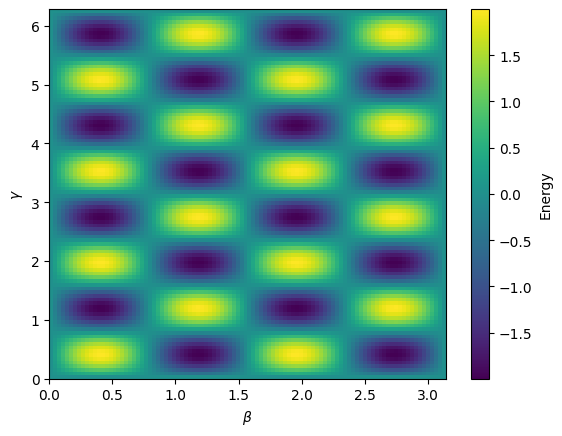

In [223]:
import matplotlib.pyplot as plt

n_points = 100
gammas = np.linspace(0, 2*np.pi, n_points)
betas = np.linspace(0, np.pi, n_points)
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0)])
p = 1
S = Simulation(G, p)
E = np.zeros((n_points, n_points))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        E[i, j]=S.sum_of_expectations([gamma, beta])
        
plt.imshow(
    E,
    extent=[betas[0], betas[-1], gammas[0], gammas[-1]],
    origin="lower",
    aspect="auto"
)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.colorbar(label="Energy")
plt.show()
        